In [19]:
import scipy.io as sio
import numpy as np
import os
import pandas as pd

path = '/Users/lukasgehrke/data/fastReach/data/eeglab2python'

pIDs = [12, 14, 15, 16, 17, 19, 20, 21, 22, 23]

intention = np.zeros((len(pIDs), 65, 1000))
augmented = np.zeros((len(pIDs), 65, 1000))
involuntary = np.zeros((len(pIDs), 65, 1000))

augmented_muscle = np.zeros((len(pIDs), 65, 1000))
augmented_ems = np.zeros((len(pIDs), 65, 1000))

i=0
for pID in pIDs:
    
    pID = 'sub-' + "%03d" % (pID)

    # load data
    erp = sio.loadmat(path+os.sep+pID+os.sep+'eeg_tap.mat')['eeg_tap']

    # load design matrix
    design = pd.read_csv(path+os.sep+pID+os.sep+'design.csv')
    
    # load mat bad noisy_trials_pre_move
    noisy_trials = sio.loadmat(path+os.sep+pID+os.sep+'noisy_trials_pre_move.mat')['noisy_trials_pre_move']
    
    # remove noisy trials from design & erp
    design = design.drop(noisy_trials.flatten(), axis=0).reset_index(drop=True)
    erp = np.delete(erp, noisy_trials.flatten(), axis=-1)

    baseline = design[design['condition'] == 'baseline']
    intention[i,:,:] = erp[:,:,baseline.index].mean(axis=-1)
    # intention[i,:,:] = erp[:,:,baseline.index].std(axis=-1)

    ems = design[design['condition'] == 'ems_bci']
    augmented[i,:,:] = erp[:,:,ems.index].mean(axis=-1)
    # augmented[i,:,:] = erp[:,:,ems.index].std(axis=-1)
    
    # select control = muscle
    ems_muscle = ems[ems['control'] == 'muscle']
    augmented_muscle[i,:,:] = erp[:,:,ems_muscle.index].mean(axis=-1)    
    ems_ems = ems[ems['control'] == 'ems']
    augmented_ems[i,:,:] = erp[:,:,ems_ems.index].mean(axis=-1)

    external = design[design['condition'] == 'ems_random']
    involuntary[i,:,:] = erp[:,:,external.index].mean(axis=-1)
    # involuntary[i,:,:] = erp[:,:,external.index].std(axis=-1)

    i+=1

/var/folders/04/2q4w_vgn0_7dtkxyll6j2gx40000gn/T/ipykernel_22040/637628897.py:45: RuntimeWarning: Mean of empty slice.
  augmented_muscle[i,:,:] = erp[:,:,ems_muscle.index].mean(axis=-1)
/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [20]:
elec = -1

intention_elec = intention[:,elec,:]
augmented_elec = augmented[:,elec,:]
involuntary_elec = involuntary[:,elec,:]
augmented_muscle_elec = augmented_muscle[:,elec,:]
augmented_ems_elec = augmented_ems[:,elec,:]

# baseline correction range from 474:499
baseline_time = np.arange(474,500)
intention_elec = intention_elec - intention_elec[:,baseline_time].mean(axis=-1)[:,np.newaxis]
augmented_elec = augmented_elec - augmented_elec[:,baseline_time].mean(axis=-1)[:,np.newaxis]
involuntary_elec = involuntary_elec - involuntary_elec[:,baseline_time].mean(axis=-1)[:,np.newaxis]
augmented_muscle_elec = augmented_muscle_elec - augmented_muscle_elec[:,baseline_time].mean(axis=-1)[:,np.newaxis]
augmented_ems_elec = augmented_ems_elec - augmented_ems_elec[:,baseline_time].mean(axis=-1)[:,np.newaxis]

df_intention = pd.DataFrame(intention_elec)
df_augmented = pd.DataFrame(augmented_elec)
df_involuntary = pd.DataFrame(involuntary_elec)
df_augmented_muscle = pd.DataFrame(augmented_muscle_elec)
df_augmented_ems = pd.DataFrame(augmented_ems_elec)

df = pd.concat([df_intention, df_augmented, df_involuntary, df_augmented_muscle, df_augmented_ems], axis=0)

# delete first 250 columns (baseline) and last 350 columns (after movement)
df = df.iloc[:,250:-351]

# add variable 'condition' with 3 levels (intention, augmented, involuntary) to df
df['condition'] = ['intention']*len(pIDs) + ['augmented']*len(pIDs) + ['involuntary']*len(pIDs) + ['augmented_muscle']*len(pIDs) + ['augmented_ems']*len(pIDs)
# add variable 'participant' with 10 levels (pID) to df (repeated pID vector 3 times)
df['participant'] = np.tile(pIDs, 5)

df_test = df.copy()

# format df from wide to long keeping 'participant' and 'condition' as id variables
df = pd.melt(df, id_vars=['participant', 'condition'], var_name='time', value_name='voltage')
df.time = df.time - 500
df.time = df.time / 250

# remove times < 1s and > 1s
df = df[(df.time >= -1) & (df.time <= .6)]

df.time = df.time * 1000

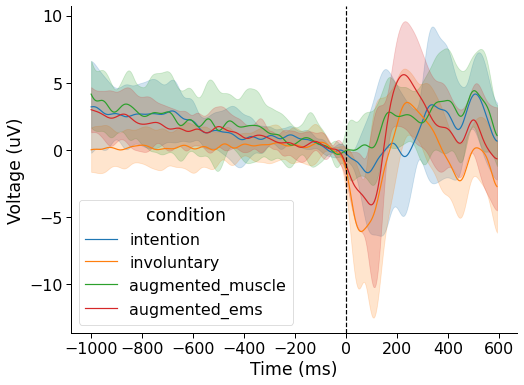

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# remove involuntary and intention from df
df = df[(df.condition == 'augmented_muscle') | (df.condition == 'augmented_ems') | (df.condition == 'intention') | (df.condition == 'involuntary')]

with sns.plotting_context('paper', font_scale = 1.8):

    ### Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    fig.patch.set_alpha(1)

    sns.despine() #bottom=True, left=True

    sns.lineplot(x='time', y='voltage', hue='condition', data=df, ax=ax, errorbar='sd')

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Voltage (uV)')

    # xline at 0
    ax.axvline(0, color='black', linestyle='--')


In [30]:
# %%capture

import pymer4 as pymer4
from pymer4.models import Lmer
from scipy.stats import chi2

# rename time columns in df_test to 'time_'
df_test.columns = ['time_' + str(col) if isinstance(col, int) else col for col in df_test.columns]

estimates = np.zeros((df_test.shape[1]-2, 5))
p_values = np.zeros((df_test.shape[1]-2, 5))

# loop over time points in df_test
i = 0
for time in df_test.columns[:-2]:

    # fit model
    full_model = Lmer(time + " ~ condition + (1|participant)", data = df_test).fit(REML = False, summarise = False)
    null_model = Lmer(time + " ~ 1 + (1|participant)", data = df_test).fit(REML = False, summarise = False)

    # assess main effect using likelihood ratio test
    p_values[i,0] = pymer4.stats.lrt([null_model,full_model])['pval'].values[0]

    # save estimates and p-values
    estimates[i,:] = full_model.T.iloc[0] # intercept, aug_ems, aug_muscle, intention, involuntary
    p_values[i,:] = full_model.T.iloc[6]
    i+=1

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: time_250~condition+(1|participant)

Family: gaussian	 Inference: parametric

Number of observations: 50	 Groups: {'participant': 10.0}

Log-likelihood: -105.795 	 AIC: 225.591

Random effects:

                    Name    Var    Std
participant  (Intercept)  0.544  0.738
Residual                  3.956  1.989

No random effect correlations specified

Fixed effects:

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your d

AttributeError: 'DataFrame' object has no attribute 'logLike'

In [25]:
# make time variable from -1000 to 600 ms in steps of 4 ms, should be the size of estimates
time = np.arange(-1000, 596, 4)

# fdr correction for multiple comparisons of p_values
from statsmodels.stats.multitest import multipletests
p_values = multipletests(p_values.flatten(), method='fdr_bh')[1].reshape(p_values.shape)

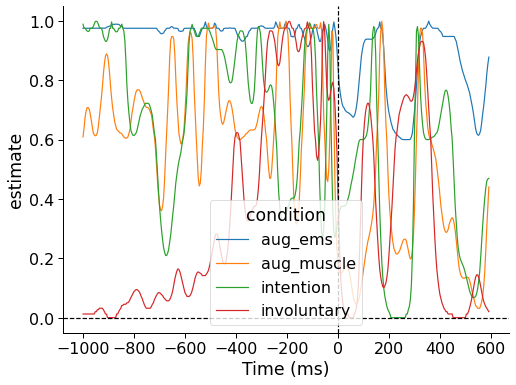

In [27]:
# create df with estimates and time
df_estimates = pd.DataFrame(p_values, columns=['intercept', 'aug_ems', 'aug_muscle', 'intention', 'involuntary'])
df_estimates['time'] = time

# format df from wide to long keeping 'time' as id variable
df_estimates = pd.melt(df_estimates, id_vars=['time'], var_name='condition', value_name='estimate')

# remove intercept from df_estimates
df_estimates = df_estimates[df_estimates.condition != 'intercept']

with sns.plotting_context('paper', font_scale = 1.8):

    ### Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    fig.patch.set_alpha(1)

    sns.despine() #bottom=True, left=True

    sns.lineplot(x='time', y='estimate', hue='condition', data=df_estimates, ax=ax)

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('estimate')

    # xline at 0
    ax.axvline(0, color='black', linestyle='--')
    # yline at 0
    ax.axhline(0, color='black', linestyle='--')

    # # add significance stars
    # for i, p in enumerate(p_values):
    #     if p < 0.05:
    #         ax.text(time[i], 0, '*', fontsize=12, ha='center', va='center')
